In [46]:
import math
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
# 单层决策树
class DTStump(object):
    """docstring for DTStump"""

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.build()

    # 叶节点选择其类别为D中样本最多的类
    def choose_largest_example(self, X):
        D = self.Y.loc[X.index]
        Count = D.value_counts()
        Max = -1
        for key, value in Count.items():
            if Max < value:
                label = key
                Max = value

        return label

    # 计算给定数据集的熵
    def calc_Ent(self, X):
        D = self.Y.loc[X.index]
        numEntries = D.shape[0]
        Count = D.value_counts()
        Ent = 0.0

        for key, value in Count.items():
            # print(Count[key])
            prob = Count[key] / numEntries
            Ent -= prob * math.log(prob, 2)

        return Ent

    # 生成连续值属性的候选划分点集合T
    def candidate_T(self, key, n):
        L = set(self.X[key])
        T = []
        a, Sum = 0, 0
        for value in L:
            Sum += value
            a += 1
            if a == n:
                T.append(Sum / n)
                a, Sum = 0, 0

        if a > 0:
            T.append(Sum / a)

        return T

    # 计算样本D基于划分点t二分后的连续值属性信息增益
    def calc_Gain_t(self, key, t, Ent_D):
        Ent = 0.0
        D_size = self.X.shape[0]

        Dv = self.X.loc[self.X[key] <= t]
        Dv_size = Dv.shape[0]

        Ent_Dv = self.calc_Ent(Dv)
        Ent += Dv_size / D_size * Ent_Dv

        Dv = self.X.loc[self.X[key] > t]
        Dv_size = Dv.shape[0]

        Ent_Dv = self.calc_Ent(Dv)
        Ent += Dv_size / D_size * Ent_Dv

        return Ent_D - Ent

    # 计算样本D基于不同划分点t二分后的连续值属性信息增益，找出最大增益划分点
    def calc_Gain(self, key, Ent_D):
        n = 2
        T = self.candidate_T(key, n)
        max_Gain, max_partition = -1, -1
        for t in T:
            Gain = self.calc_Gain_t(key, t, Ent_D)
            if max_Gain < Gain:
                max_Gain = Gain
                max_partition = t

        return max_Gain, max_partition

    # 从A中选择最优的划分属性值，返回划分点
    def build(self):
        self.stump = {}
        max_Gain = -1
        for key in self.X.columns:
            Ent_D = self.calc_Ent(self.X)
            Gain, partition = self.calc_Gain(key, Ent_D)

            if max_Gain < Gain:
                best_attr = key
                max_Gain = Gain
                max_partition = partition

        left = self.X.loc[self.X[best_attr] <= partition]
        right = self.X.loc[self.X[best_attr] > partition]

        if left.shape[0] == 0:
            self.stump[0] = self.choose_largest_example(self.X)
        else:
            self.stump[0] = self.choose_largest_example(left)



        if right.shape[0] == 0:
            self.stump[1] = self.choose_largest_example(self.X)
        else:
            self.stump[1] = self.choose_largest_example(right)

        self.attribute, self.partition = best_attr, max_partition
        # print(self.attribute, self.partition, self.stump)

    # 输入测试数据，输出预测标签类
    def predict(self, X):
        value = X[self.attribute]
        if value <= self.partition:
            return self.stump[0]
        else:
            return self.stump[1]

In [48]:
class Bagging(object):
    """docstring for Bagging"""
    def __init__(self, iterate=100):
        self.num = iterate

    # 输入训练集数据和对应标签，训练集成学习器
    def fit(self, X, Y):
        size = X.shape[0]
        weakClassers = []  # 保存每次迭代器的信息
        for _ in range(self.num):
            indexs = [rd.randint(0, size -1) for _ in range(size)]
            # indexs = [a for a in range(size)]

            DX = pd.DataFrame(data=X.loc[indexs]).reset_index(drop=True)
            DY = pd.Series(data=Y.loc[indexs]).reset_index(drop=True)

            weakClasser = DTStump(DX, DY)
            weakClassers.append(weakClasser)  # 保存每一轮的结果信息

        self.weakClassers = weakClassers
        return self

    # 输入测试集，输出集成学习器预测预测的标签类，分类任务使用简单投票法
    def predict(self, X):
        predict_Y = []
        for index, row in X.iterrows():
            vote = 0
            lable=0
            for weakClasser in self.weakClassers:
                label = weakClasser.predict(row)
                l=lable*2-1
                vote+=l
            aa=(vote>=0)+0
            predict_Y.append(aa)

        return predict_Y

In [85]:
# 绘制数据集
def pltDecisionBound(dataSet, X,Y,clf):
    X=np.array(X)
    Y=np.array(Y)
    X1 = np.array(dataSet[dataSet['label'] == 1][['density', 'sugar_rate']])
    X2 = np.array(dataSet[dataSet['label'] == 0][['density', 'sugar_rate']])

    x = np.linspace(0, 0.8, 100)
    y = np.linspace(0, 0.6, 100)
    y_p=np.zeros(17)
    for weakClasser in clf.weakClassers:
        #print(weakClasser.attribute, weakClasser.partition)
        z = [weakClasser.partition] * 100
        if weakClasser.attribute == 'density':
            plt.plot(z, y)
            xx=X[:,0]>weakClasser.partition
            xx=xx.astype(np.int64)
            xx=xx*2-1
            y_p=y_p+xx
        else:
            plt.plot(x, z)
            yy=X[:,1]>weakClasser.partition
            yy=yy.astype(np.int64)
            yy=yy*2-1
            y_p=y_p+yy
    y_p=y_p>=0
    y_p=y_p.astype(np.int64)

    plt.scatter(X1[:, 0], X1[:, 1], marker='+',s=100, label='Good', color='b')
    plt.scatter(X2[:, 0], X2[:, 1], marker='_', s=100,label='Bad', color='r')
    plt.xlabel('Density')
    plt.ylabel('Sugar_rate')
    plt.xlim(0, 0.8) # 设置x轴范围
    plt.ylim(0, 0.6) # 设置y轴范围
    plt.legend(loc='upper left')
    plt.show()
    accuracy=sum(Y==y_p)
    print('Accuracy:', accuracy, '/', Y.shape[0])
    
    

In [86]:
data = [[0.697, 0.460, 1],
        [0.774, 0.376, 1],
        [0.634, 0.264, 1],
        [0.608, 0.318, 1],
        [0.556, 0.215, 1],
        [0.430, 0.237, 1],
        [0.481, 0.149, 1],
        [0.437, 0.211, 1],
        [0.666, 0.091, 0],
        [0.243, 0.267, 0],
        [0.245, 0.057, 0],
        [0.343, 0.099, 0],
        [0.639, 0.161, 0],
        [0.657, 0.198, 0],
        [0.360, 0.370, 0],
        [0.593, 0.042, 0],
        [0.719, 0.103, 0]]

column = ['density', 'sugar_rate', 'label']
dataSet = pd.DataFrame(data, columns=column)
X = dataSet[['density', 'sugar_rate']]
y = dataSet['label']

NO. 1


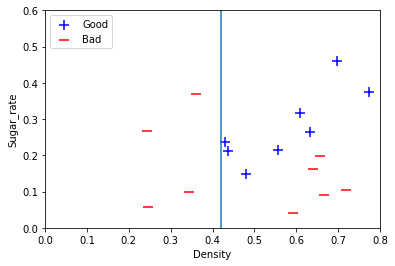

Accuracy: 12 / 17
NO. 2


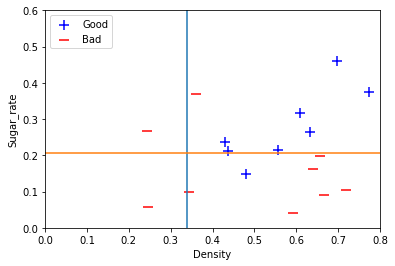

Accuracy: 9 / 17
NO. 3


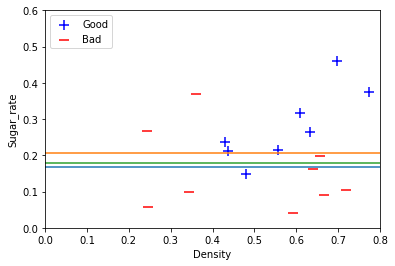

Accuracy: 13 / 17
NO. 4


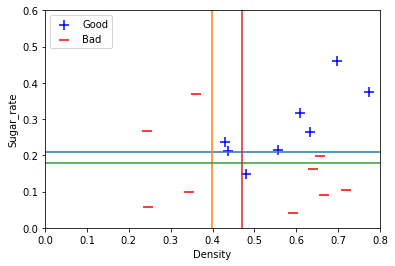

Accuracy: 10 / 17
NO. 5


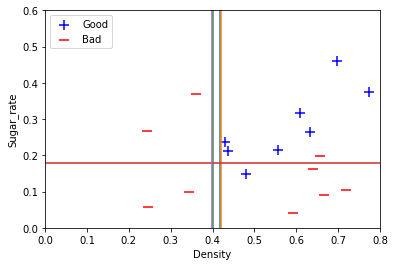

Accuracy: 12 / 17
NO. 6


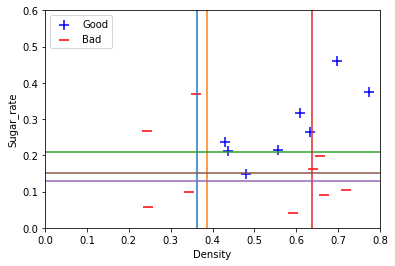

Accuracy: 11 / 17
NO. 7


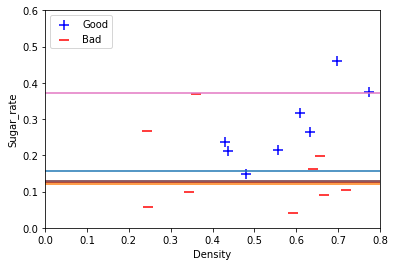

Accuracy: 13 / 17
NO. 8


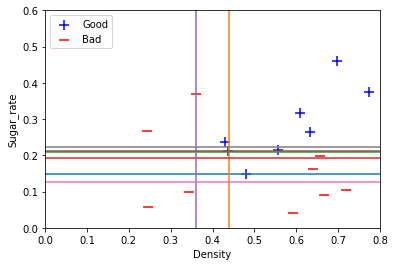

Accuracy: 13 / 17
NO. 9


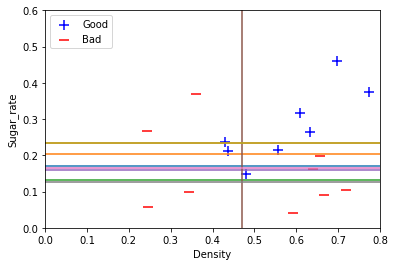

Accuracy: 13 / 17
NO. 10


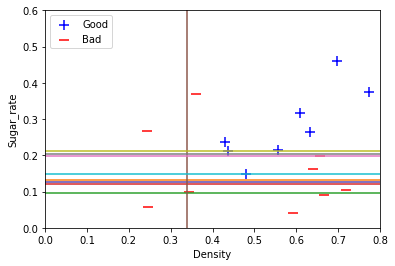

Accuracy: 13 / 17
NO. 11


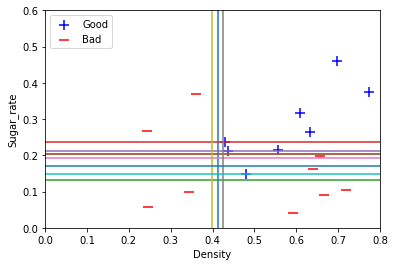

Accuracy: 13 / 17
NO. 12


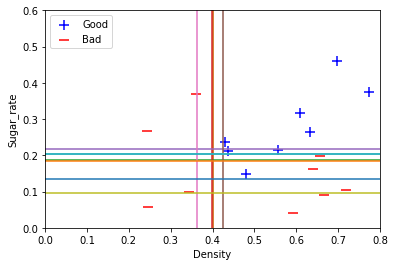

Accuracy: 12 / 17
NO. 13


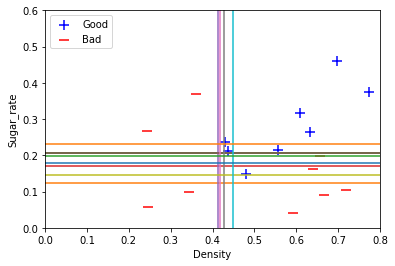

Accuracy: 13 / 17
NO. 14


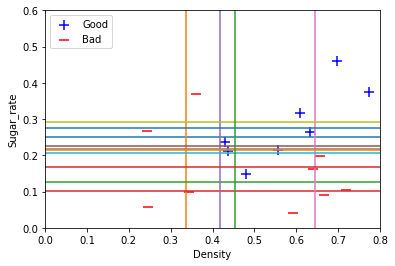

Accuracy: 12 / 17
NO. 15


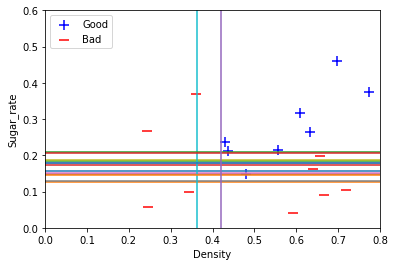

Accuracy: 12 / 17
NO. 16


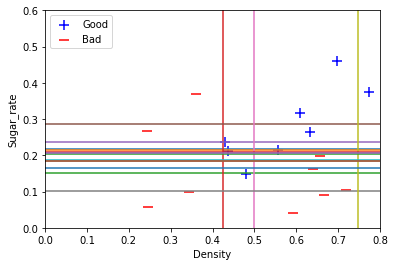

Accuracy: 13 / 17
NO. 17


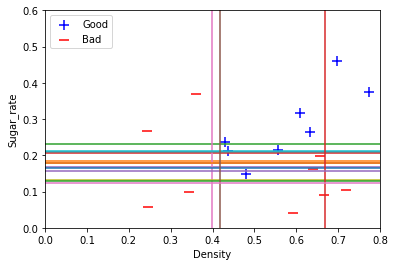

Accuracy: 13 / 17
NO. 18


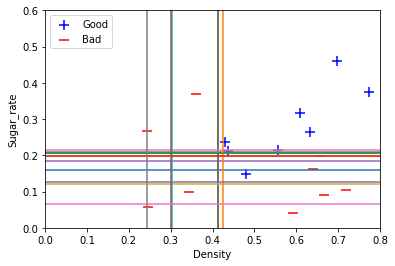

Accuracy: 13 / 17
NO. 19


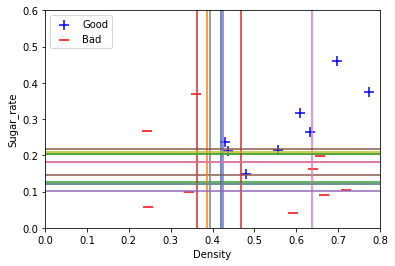

Accuracy: 13 / 17
NO. 20


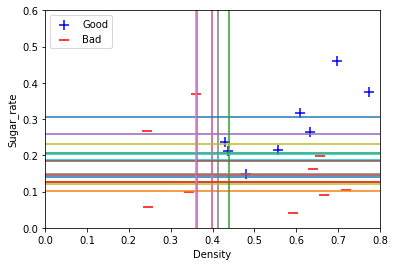

Accuracy: 13 / 17
NO. 21


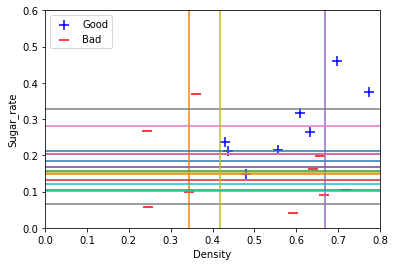

Accuracy: 13 / 17
NO. 22


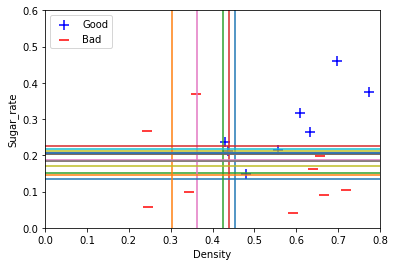

Accuracy: 13 / 17
NO. 23


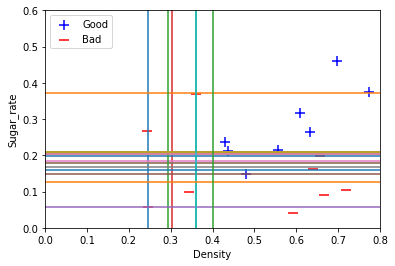

Accuracy: 13 / 17
NO. 24


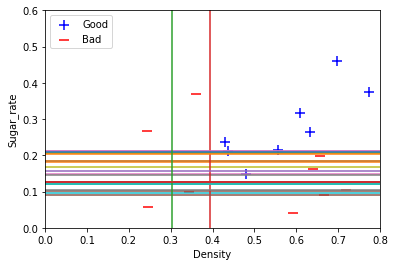

Accuracy: 13 / 17
NO. 25


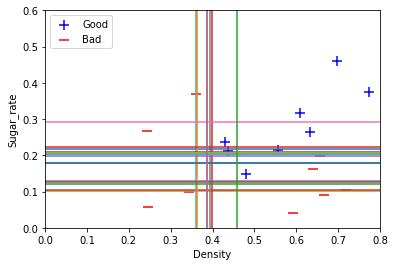

Accuracy: 13 / 17
NO. 26


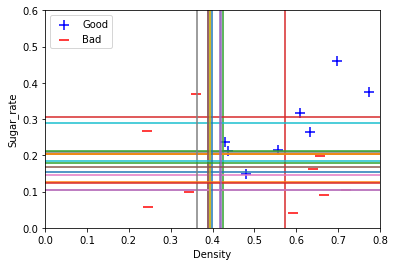

Accuracy: 13 / 17
NO. 27


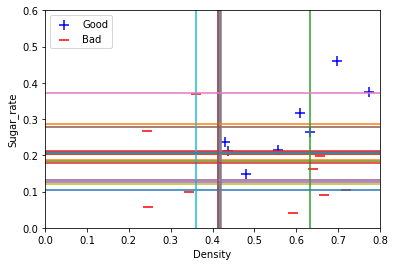

Accuracy: 13 / 17
NO. 28


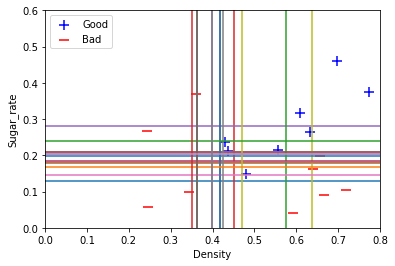

Accuracy: 12 / 17
NO. 29


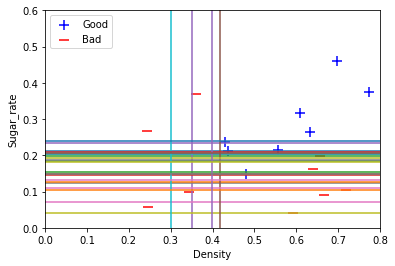

Accuracy: 13 / 17
NO. 30


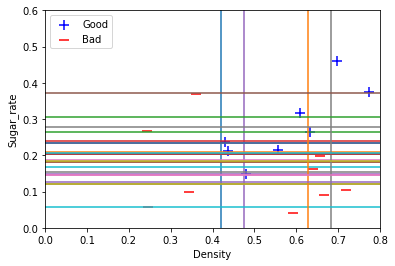

Accuracy: 13 / 17


In [88]:
T=30
H=[]
for n in range(1,T+1):
    clf = Bagging(n)
    clf = clf.fit(X, y)
    # predict_Y=clf.predict(X)
    # accuracy=sum(y==predict_Y)
    print('NO.', n)
    # print('Accuracy:', accuracy, '/', y.shape[0])
    # print('')
    pltDecisionBound(dataSet, X,y,clf)